## MSDS 7331 - Case Study 5- Cybersecurity and Firewall Traffic Automation
Daniel Crouthamel

Sophia Wu

Fabio Savorgnan

Bo Yun



In [1]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Yellowbrick
from yellowbrick.model_selection import FeatureImportances

#Pipeline
from sklearn.pipeline import make_pipeline

# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
from scipy.io import arff

# Introduction

In this study, we will be building a classifier to predict whether or not firewall requests should be automated.

# Business Understanding

MisoRobotics is an emerging startup that automates burger and wing flipping using Ai and robotics. They are currently in Series D of funding and their firewall is getting hammered by a lot of malicious traffic. They are once again asking the rock star SMU Data Science department to develop an model to determine whether or not to accept or deny access to requests coming in through their firewall. The model needs to be accurate and fast. 

# Data Engineering

We load the data which has 65532 and 12 columns including the target. We found that the dataset does not have any missing values. All the columns are numbers and are skew, please see the graph below. We will be using for our selected model svm, therefore, the skew shape of the data is not going to be a problem. The target values are multiclass. But it would make send due to the objective at hand to convert the multi class target to binary classification, which would be allow and deny. Therefore, the target values drop, and reset-both are being put together in the deny value for our binary classification. The final target class has 37640 allow and 27892 deny is mildly unbalanced but in our model with the balanced hyperparameter in the SGD will take care of the mildly unbalanced target. Finally we checked for missing values where we found no missing values, therefore there is not a necessity to impute any missing data. 

# Load the data

In [2]:
df = pd.read_csv('data/log2.csv')
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [3]:
df.shape

(65532, 12)

# EDA

In [4]:
p = df.describe()
p

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [5]:
# Check for missing data
for i in df.columns:
    if i == "Action":
        continue
    if p.loc["count", i] != df.shape[0]:
        print (i)
print("No missing data")

No missing data


array([[<AxesSubplot:title={'center':'Source Port'}>,
        <AxesSubplot:title={'center':'Destination Port'}>,
        <AxesSubplot:title={'center':'NAT Source Port'}>],
       [<AxesSubplot:title={'center':'NAT Destination Port'}>,
        <AxesSubplot:title={'center':'Bytes'}>,
        <AxesSubplot:title={'center':'Bytes Sent'}>],
       [<AxesSubplot:title={'center':'Bytes Received'}>,
        <AxesSubplot:title={'center':'Packets'}>,
        <AxesSubplot:title={'center':'Elapsed Time (sec)'}>],
       [<AxesSubplot:title={'center':'pkts_sent'}>,
        <AxesSubplot:title={'center':'pkts_received'}>, <AxesSubplot:>]],
      dtype=object)

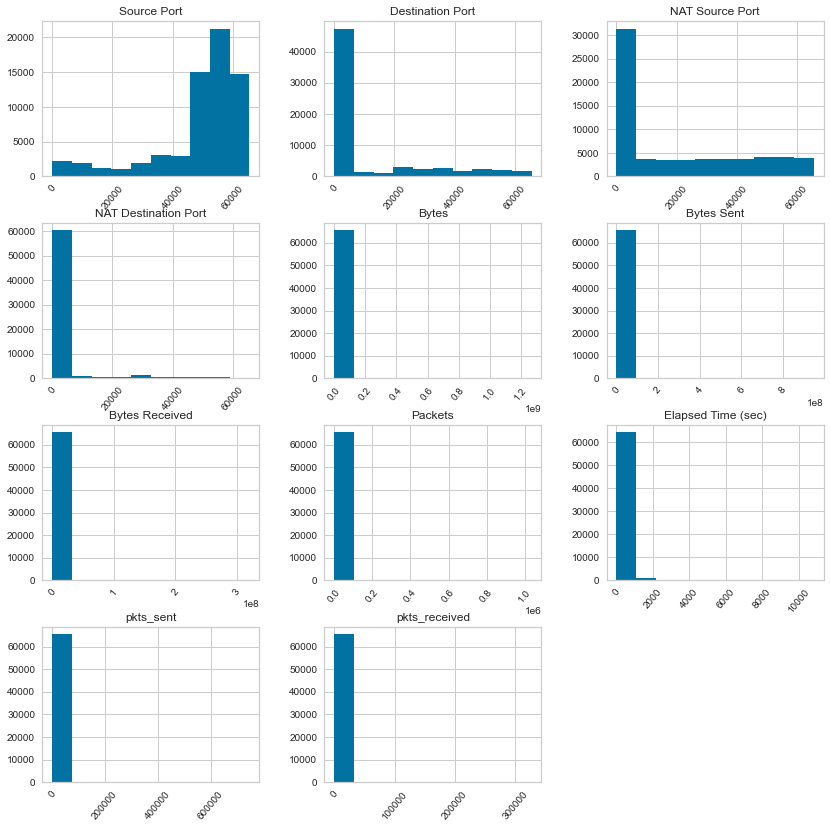

In [6]:
df.hist(figsize=(14,14), xrot=50)

# Explore the target

In [7]:
df["Action"].unique
# This show that the target is very inbalanced
df["Action"].value_counts(normalize=False)

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

(array([37640.,     0.,     0., 12851.,     0.,     0., 14987.,     0.,
            0.,    54.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

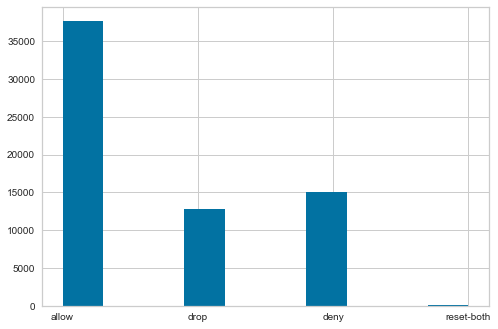

In [8]:
# Plot to better show the inbalanced target
plt.hist(df["Action"])

# We made the target binary

In [9]:
# Make the target binary
# target= []

# for i in df["Action"]:
#     if i == "allow":
#         target.append("Allow")
#     if i == "deny":
#         target.append("Deny")
#     if i == "drop":
#         target.append("Deny")
#     if i == "reset-both":
#         target.append("Deny")

# df["target"]= target


df['target'] = df['Action'].map({'allow': "Allow", 'deny': "Deny", 'drop': "Deny", 'reset-both': "Deny"})

In [10]:
df["target"].value_counts(normalize=False)

Allow    37640
Deny     27892
Name: target, dtype: int64

# Final detaset

In [11]:

df.drop(columns="Action", inplace= True)
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,target
0,57222,53,54587,53,177,94,83,2,30,1,1,Allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,Allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,Allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,Allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,Allow


# Model Preparation

We will split our dataset in train and test with 70% train and 30% test. 

Then we will prepare our SVM model. We set up a grid search, in the gird search we will explore the best kernel and the best C hyperparameter.
Cfloat, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
kernel{‘linear’, ‘rbf}, default=’rbf’
Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

The second model that we will use to compare with the SVM model is the SGD.
In the SGM classifier we decided to use the logistic regression classifier with a penalty of l2. Then we run a grid search to find the best alpha value.

Finally, we will create a third model that uses roughly 50% of the data, by extracting data that doesn't need to be modeled using Association Rules. We then run another SVM model using the best params above.


# SVM

In [12]:
# prepare test and train data

X = df.loc[:, df.columns != 'target'].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [13]:
from sklearn.svm import SVC
import pickle

param_grid= {'kernel': ('linear', 'rbf'),
            'C': [0.1, 1, 10, 100]}

base_estimator = SVC(gamma='scale')

start = time()

# grid_search = GridSearchCV(base_estimator, param_grid= param_grid)
# grid_search.fit(X_train, y_train)
grid_file = open("data/gridsearch.pickle", "rb")
grid_search = pickle.load(grid_file)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
       % (time() - start, len(grid_search.cv_results_['params'])))


# You can use the code below to save the grid search object


# gs_file = open("data/gridsearch.pickle", "wb")
# pickle.dump(grid_search, gs_file)
# gs_file.close()

# import pickle
# read_test = open("data/gridsearch.pickle", "rb")
# test_grid_search = pickle.load(read_test)
# print(test_grid_search.best_estimator)

GridSearchCV took 0.00 seconds for 8 candidate parameter settings.


# Number of support vectors

In [14]:
len(grid_search.best_estimator_.n_support_)

2

# Evaluation of the model

We decided that for the objective at hand the accuracy is the most important parameter to keep in mind. We want to make sure that we get it right.

The accuracy formula helps to know the errors in the measurement of values. If the measured value is equal to the actual value, then it is said to be highly accurate and with low errors. Accuracy and error rate are inversely related. High accuracy refers to low error rate, and high error rate refers to low accuracy. The accuracy formula gives the accuracy as a percentage value, and the sum of accuracy and error rate is equal to 100 percent. Therefore, the accuracy will be the evaluating measure for selection of our model.

We decided that for the objective at hand the accuracy is the most important parameter to keep in mind. We want to make sure that we get it right.

The accuracy formula helps to know the errors in the measurement of values. If the measured value is equal to the actual value, then it is said to be highly accurate and with low errors. Accuracy and error rate are inversely related. High accuracy refers to low error rate, and high error rate refers to low accuracy. The accuracy formula gives the accuracy as a percentage value, and the sum of accuracy and error rate is equal to 100 percent. Therefore, the accuracy will be the evaluating measure for selection of our model.

We decided to select the svm model with an accuracy of 99.7%. There are only 55 misclassifications from 21626 classification target. For completeness the recall is 99.6% and the precision is 99.5%. The best hyperparameters were the linear kernel and the penalty of 1. 
The feature that contributes the most for this svm classifier were ‘Elapsed Time’, ‘Packets’ and ‘pkts_sent’. This model builds 2 support vectors as the classification boundary. 

The competing model has high accuracy and recall also, please see the code, accuracy 99.3% recall 99.6% and precision 99.5%. The best hyperparameters used in this competing model were 'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'. The most important feature in this model were ‘Bytes received’, ‘Bytes’, ‘Elapsed Time’ as the previous selected model. 




# Evaluation of the svm model

In [15]:
y_hat_rf_train = grid_search.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

0.9975174235867535

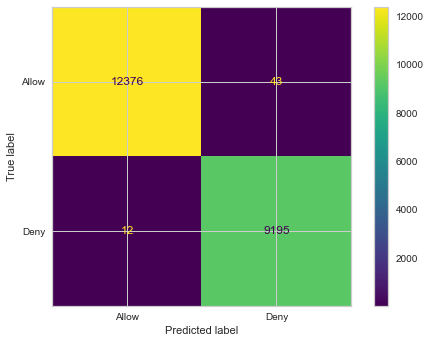

In [16]:
# Confusion matrix train
confusion_matrix(y_train, y_hat_rf_train)
disp = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)

In [17]:
y_hat_rf_test = grid_search.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

0.9974567650050865

In [18]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label="Allow", average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label="Deny", average='binary'))

Recall: 0.9965375634109026
Precision: 0.9953453128382767


# Plot

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

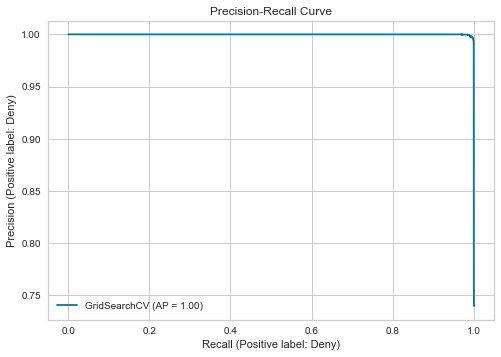

In [19]:
disp = plot_precision_recall_curve(grid_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

# ROC

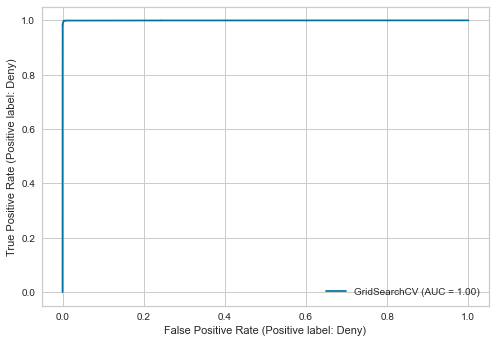

In [20]:
Disp = RocCurveDisplay.from_estimator(grid_search, X_test, y_test)

# Evaluation of the hyperparameters

### SVM Model parameter evaluation

### `Linear vs Rbf` kernel 
- Linear kernel shows a very high accuracy score, whereas rbf shows a significant drop in accuracy. 
- Too high accuracy for linear suggests the need to adjust the model with regularization. 

In [21]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

p=  ['linear', 'rbf']

for i in p:
    model = SVC(kernel= i)
    model.fit(X_train, y_train)
    y_hat_rf_test = model.predict(X_test)
    print(i,":", accuracy_score(y_hat_rf_test, y_test)) 



linear : 0.9974567650050865
rbf : 0.6335429575510959


- Below is a graphical representation of how each kernel separates the data with 400 sample data.
- The rbf method tells that it is selecting more support vectors than needed and also its boundary(dotted line) is smaller than needed to correctly identify the target cell. Thus this results in lower accuracy. 

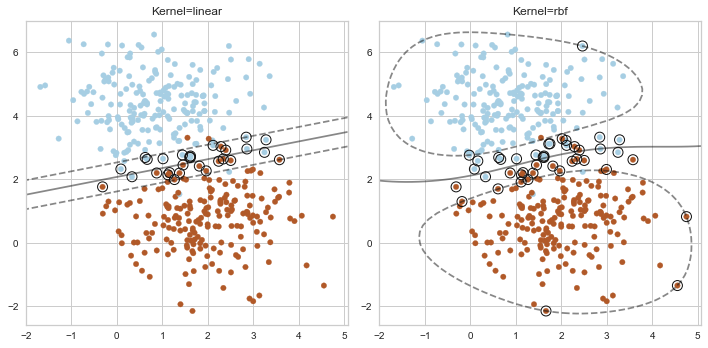

In [26]:
# prepare test and train data
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'target'].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=400, centers=2, random_state=0)
plt.figure(figsize=(10, 5))

for i, K in enumerate(['linear','rbf']):
    # "hinge" is the standard SVM loss
    clf = SVC(C=1, kernel=K, random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(
        np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("Kernel=" + str(K))
    
plt.tight_layout()
plt.show()

### `Different C(Regularization)` comparison between different kernels
- C of 10 showed the highest accuracy

In [27]:
C= [0.1, 1, 10]

for i in C:
    model = SVC(C= i)
    model.fit(X_train, y_train)
    y_hat_rf_test = model.predict(X_test)
    print(str(i), ":", accuracy_score(y_hat_rf_test, y_test)) 

0.1 : 0.5742624618514751
1 : 0.6335429575510959
10 : 0.8671044113567002


#### `Linear kernel`
- It is shown that C=0.1 is allowing too much margin around the hyperplane that it incorrectly identies a lot of the data points. 
- When c=10, it appears that it reached the ideal margin space, which is validated by the accuracy result from above. 

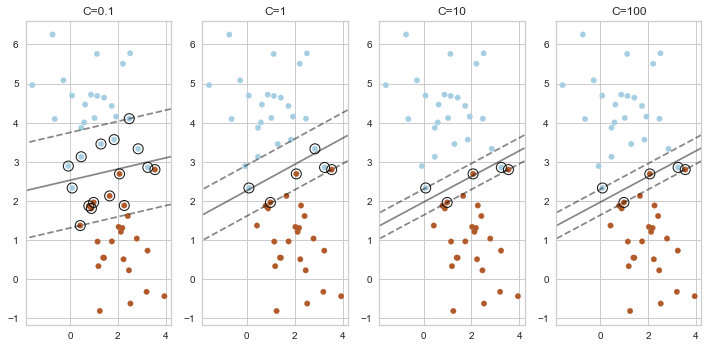

In [28]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0)

plt.figure(figsize=(10, 5))

for i, C in enumerate([0.1,1,10,100]):
    # "hinge" is the standard SVM loss
    clf = SVC(C=C, kernel='linear', random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(
        np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 4, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    
plt.tight_layout()
plt.show()

#### `Rbf kernel`
- Here is a very good representation of how the regularization term C affects the model. 
- As seen here, smaller C value causes a larger-margin separating hyperplane, and it leads to misclassification. 

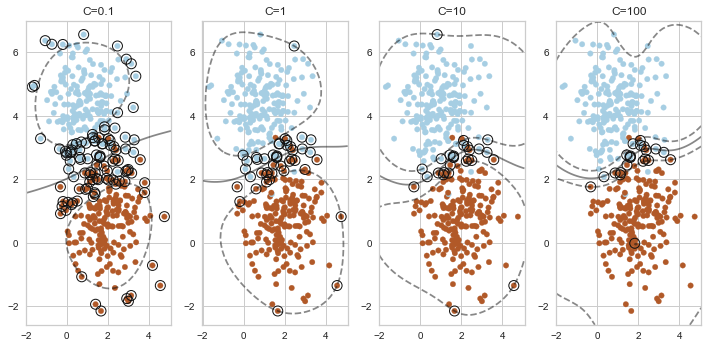

In [29]:
X, y = make_blobs(n_samples=400, centers=2, random_state=0)
plt.figure(figsize=(10, 5))

for i, C in enumerate([0.1,1,10,100]):
    # "hinge" is the standard SVM loss
    clf = SVC(C=C, kernel='rbf', random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(
        np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 4, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    
plt.tight_layout()
plt.show()

### `Support Vector distribution` for each feature
- Here are kernel density plots describing the behavior and distribution of support vectors for each feature. 
- The key takeaway is observing how much the distribution of support vectors are different from the original data. 
- Support vector representation for features such as __Elaspted Time__, __Packets__, __pkts_sent__, __pkts_received__, __Bytes__ show the most significant difference from its original data, meaning their contribution to the classification model is the most significant. This finding matches with the result from feature importance barplot below. 

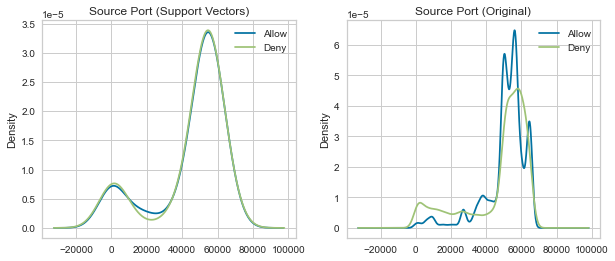

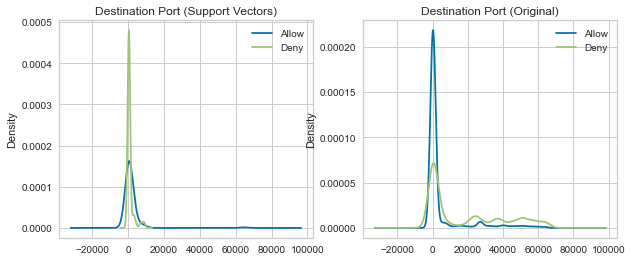

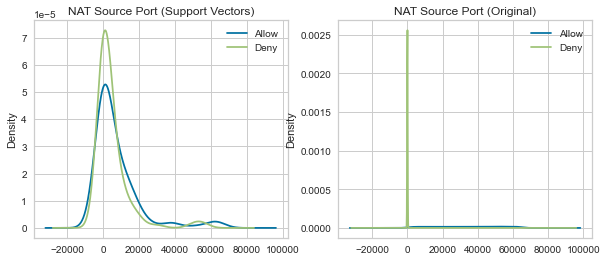

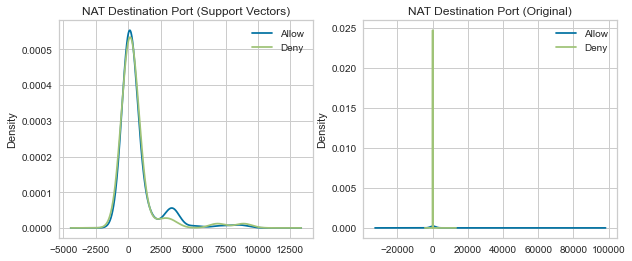

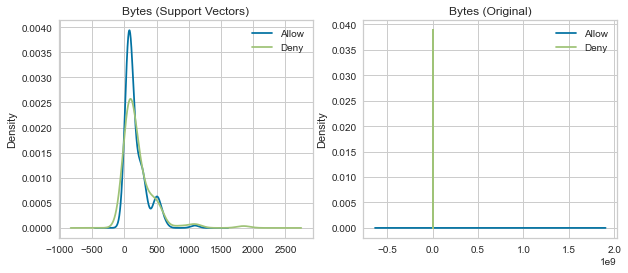

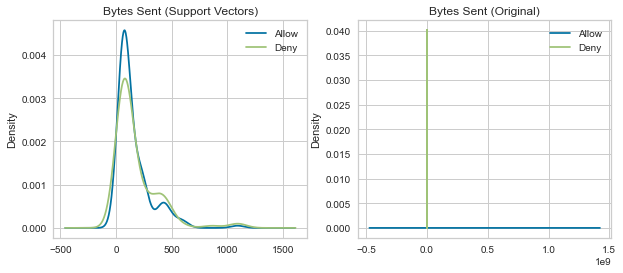

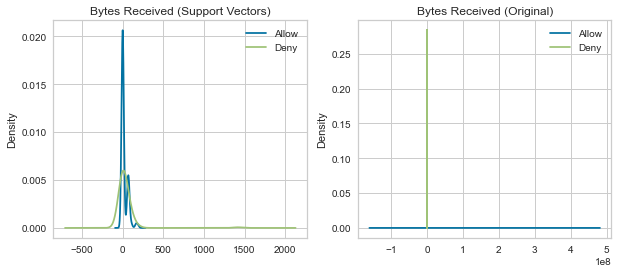

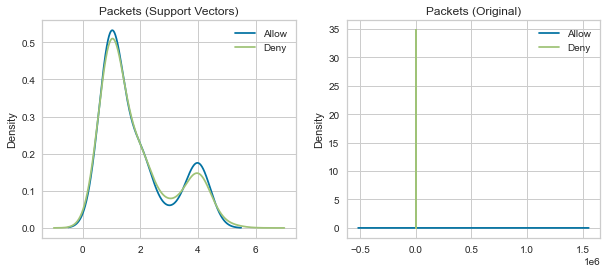

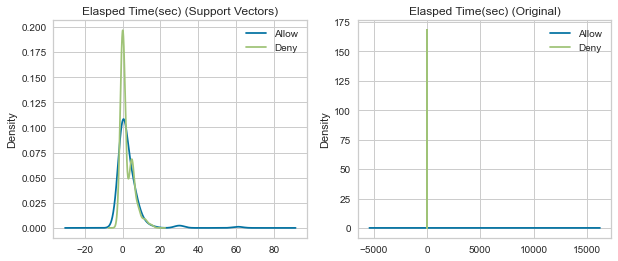

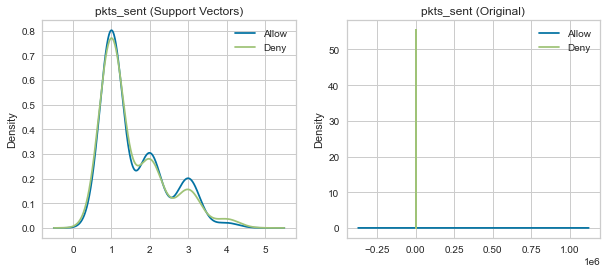

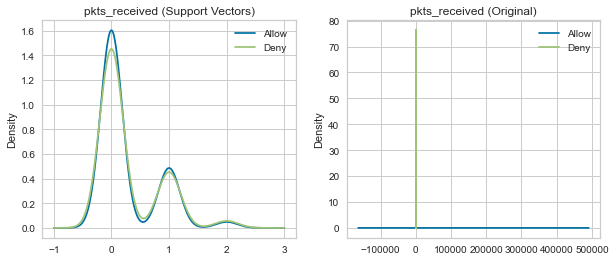

In [30]:
# Loading linear SVM using original dataset
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
import pandas
from pandas.plotting import boxplot

# Using cross validation, test/train split 80:20
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size= 0.2, random_state=42) 

X = df.loc[:, df.columns != 'target'].values
y = df['target'].values

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]


# train the model just as before
svm_clf = SVC(C=10, kernel='linear', random_state=10) # get object
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

# Select the rows of the train indices and make df_tested_on dataframe
df_tested_on = X[train_indices]

# now get the support vectors from the trained model
df_support = df_tested_on[svm_clf.support_,:].copy()
df_support = pd.DataFrame(df_support, columns = ["Source Port","Destination Port","NAT Source Port","NAT Destination Port","Bytes","Bytes Sent","Bytes Received","Packets","Elasped Time(sec)","pkts_sent","pkts_received"])
df_support['target'] = y[svm_clf.support_].copy() # add back in the 'target' Column to the pandas dataframe

X = X.copy()
X = pd.DataFrame(X, columns = ["Source Port","Destination Port","NAT Source Port","NAT Destination Port","Bytes","Bytes Sent","Bytes Received","Packets","Elasped Time(sec)","pkts_sent","pkts_received"])
X['target'] = y # also add it back in for the original data
df_support=df_support.dropna()


# group the original data and the support vectors
df_grouped_support = df_support.groupby(['target'])
df_grouped = X.groupby(['target'])

# plot KDE of Different variables
vars_to_plot = ["Source Port","Destination Port","NAT Source Port","NAT Destination Port","Bytes","Bytes Sent","Bytes Received","Packets","Elasped Time(sec)","pkts_sent","pkts_received"]

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Allow','Deny'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Allow','Deny'])
    plt.title(v+' (Original)')

# Best hyperparams after the gridsearch evaluated above

In [24]:
grid_search.best_params_


{'C': 1, 'kernel': 'linear'}

# Feature importance

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


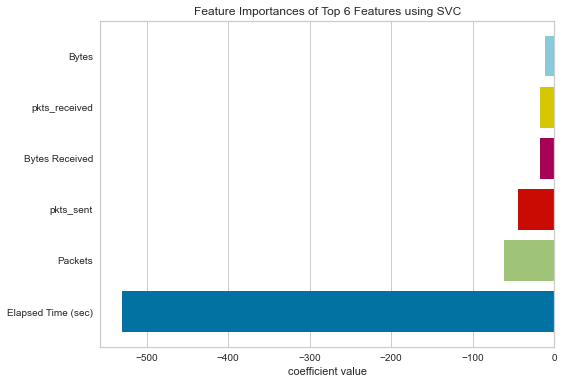

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using SVC'}, xlabel='coefficient value'>

In [25]:
best= grid_search.best_estimator_
viz = FeatureImportances(best, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()

# SGD

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    'loss': ['log'],
    'penalty': ['l2'],
    'alpha': [10 ** x for x in range(-3, 1)],
}
clf = SGDClassifier(random_state=0, class_weight='balanced', max_iter=100)

clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                                    n_jobs=-1, scoring='accuracy')

clf_grid.fit(X_train, y_train)
y_hat_rf_train = clf_grid.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:707: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


0.9935088598369244

# SGD best parameter

In [46]:
clf_grid.best_params_

{'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}

# Evaluation of the SGD model

In [42]:
y_hat_rf_train = clf_grid.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

0.9935088598369244

In [43]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label="Allow", average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label="Deny", average='binary'))

Recall: 0.9965375634109026
Precision: 0.9953453128382767


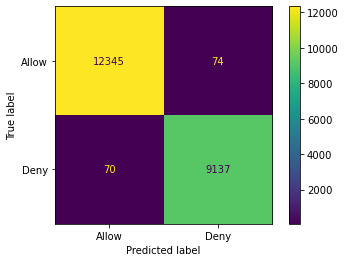

In [47]:
disp = ConfusionMatrixDisplay.from_estimator(clf_grid, X_test, y_test)

# Plot precision and recall

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

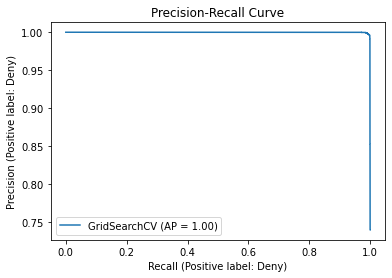

In [44]:
disp = plot_precision_recall_curve(grid_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

# AUC

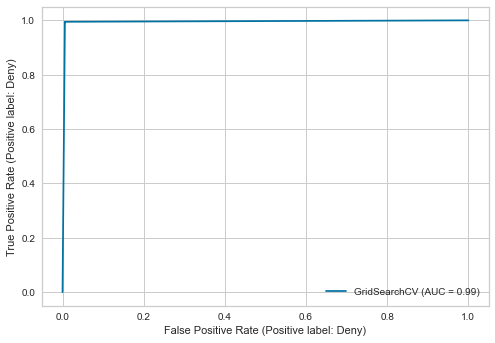

In [57]:
Disp = RocCurveDisplay.from_estimator(clf_grid, X_test, y_test)

# Feature importance

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


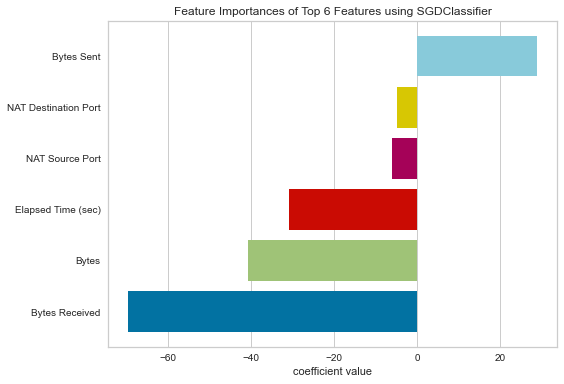

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using SGDClassifier'}, xlabel='coefficient value'>

In [62]:
best= clf_grid.best_estimator_
viz = FeatureImportances(best, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()

# Reduced Dataset Model using AR Rules

Let's take a look at using Association Rules to see if we can skim off some what appear to be known facts, i.e., that certain ports will probably always be Allow or Deny. This is information we should share with our stakeholders to determine accuracy, since we are not experts in Cybersecurity.

We will first reduce the data set to just the port columns and target, and then use the apriori algorithm to find the association rules.

Recommended Reading:  
https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c  
https://towardsdatascience.com/using-association-rules-with-categorical-data-e984f8bb8ee4  
http://rasbt.github.io/mlxtend/  

In [22]:
from mlxtend.frequent_patterns import apriori, association_rules

reduced_df = df[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'target']].copy(deep=True)

reduced_df.sample(frac=0.1, random_state=42)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,target
43957,51313,64147,0,0,Deny
4530,49949,443,7206,443,Allow
6666,64070,53,27144,53,Allow
25400,61279,445,0,0,Deny
36054,51983,443,27301,443,Allow
...,...,...,...,...,...
51022,58944,445,0,0,Deny
6128,33733,443,7805,443,Allow
46494,50095,30188,0,0,Deny
25996,36881,443,36881,443,Allow


We are going to treat the ports as categorical data, and then use the apriori algorithm to find the association rules between this items, along with finding those rules that end with Deny or Allow. Let's use the Pandas get_dummies function to convert our matrix to a spare matrix of 0s and 1s, to indicate whether or not a given row (request) uses a given port.

In [23]:
reduced_df = pd.get_dummies(reduced_df, columns=reduced_df.columns)
reduced_df.sample(frac=0.1, random_state=42)

,Source Port_0,Source Port_5,Source Port_20,Source Port_22,Source Port_25,Source Port_50,Source Port_67,Source Port_68,Source Port_80,Source Port_123,...,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535,target_Allow,target_Deny
43957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
36054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
46494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Below we will use the apriori algorithm to find the association rules between the ports. The rules are then further filtered to only include those that end (Consequents) with Deny or Allow. We are interested in understanding what combination of ports lead to that outcome.

For more information on metrics, please reference the below link.

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

In [24]:
frequent_itemsets = apriori(reduced_df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.head(10).sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Destination Port_80),(NAT Destination Port_80),0.061573,0.061466,0.061466,0.998265,16.240892,0.057682,540.997724
5,(NAT Destination Port_80),(Destination Port_80),0.061466,0.061573,0.061466,1.000000,16.240892,0.057682,inf
8,(Destination Port_443),(NAT Destination Port_443),0.178295,0.178203,0.178203,0.999486,5.608696,0.146430,1600.312661
9,(NAT Destination Port_443),(Destination Port_443),0.178203,0.178295,0.178203,1.000000,5.608696,0.146430,inf
0,(NAT Destination Port_53),(Destination Port_53),0.230330,0.235213,0.230330,1.000000,4.251460,0.176153,inf
1,(Destination Port_53),(NAT Destination Port_53),0.235213,0.230330,0.230330,0.979240,4.251460,0.176153,37.074031
6,(Destination Port_80),(target_Allow),0.061573,0.574376,0.061466,0.998265,1.738000,0.026100,245.341905
7,(target_Allow),(Destination Port_80),0.574376,0.061573,0.061466,0.107014,1.738000,0.026100,1.050886
2,(Destination Port_53),(target_Allow),0.235213,0.574376,0.234771,0.998119,1.737745,0.099670,226.226559
3,(target_Allow),(Destination Port_53),0.574376,0.235213,0.234771,0.408741,1.737745,0.099670,1.293488


In [26]:
target = '{\'target_Allow\'}'

results_filter = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_filter.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
24,(NAT Destination Port_53),(target_Allow),0.230330,0.574376,0.230330,1.000000,1.741020,0.098034,inf
26,(NAT Destination Port_80),(target_Allow),0.061466,0.574376,0.061466,1.000000,1.741020,0.026161,inf
30,"(NAT Destination Port_53, Destination Port_53)",(target_Allow),0.230330,0.574376,0.230330,1.000000,1.741020,0.098034,inf
36,"(Destination Port_80, NAT Destination Port_80)",(target_Allow),0.061466,0.574376,0.061466,1.000000,1.741020,0.026161,inf
28,(NAT Destination Port_443),(target_Allow),0.178203,0.574376,0.178188,0.999914,1.740871,0.075832,4970.438503
42,"(Destination Port_443, NAT Destination Port_443)",(target_Allow),0.178203,0.574376,0.178188,0.999914,1.740871,0.075832,4970.438503
10,(Destination Port_443),(target_Allow),0.178295,0.574376,0.178188,0.999401,1.739977,0.075780,710.427464
6,(Destination Port_80),(target_Allow),0.061573,0.574376,0.061466,0.998265,1.738000,0.026100,245.341905
2,(Destination Port_53),(target_Allow),0.235213,0.574376,0.234771,0.998119,1.737745,0.099670,226.226559


In [27]:
target = '{\'target_Deny\'}'

results_filter = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
results_filter.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(Destination Port_445),(target_Deny),0.196713,0.425624,0.196713,1.000000,2.349491,0.112987,inf
55,"(NAT Source Port_0, Destination Port_445)",(target_Deny),0.196713,0.425624,0.196713,1.000000,2.349491,0.112987,inf
61,"(NAT Destination Port_0, Destination Port_445)",(target_Deny),0.196713,0.425624,0.196713,1.000000,2.349491,0.112987,inf
73,"(NAT Source Port_0, NAT Destination Port_0, De...",(target_Deny),0.196713,0.425624,0.196713,1.000000,2.349491,0.112987,inf
20,(NAT Source Port_0),(target_Deny),0.433864,0.425624,0.425258,0.980163,2.302885,0.240595,28.955062
22,(NAT Destination Port_0),(target_Deny),0.433864,0.425624,0.425258,0.980163,2.302885,0.240595,28.955062
66,"(NAT Source Port_0, NAT Destination Port_0)",(target_Deny),0.433864,0.425624,0.425258,0.980163,2.302885,0.240595,28.955062


Based on the above, we could propose the following rules for Allow and Deny.

Allow Case
We can see that if the NAT Destination Port is either 53 or 80, it's always going to be Allow. You can almost make the same argument for the Destination Port. It's confidence is near 1. We do have some data that shows it could be Deny, but let's make the assumption that it's always Allow. This is something we can discuss with our stakeholders.

Deny Case

We see above that if the Destination Port is 445, it's always deny. So we can remove that data. We do also see that if the NAT Source or NAT Destination Port is 0, it's almost always deny. It's tempting to remove this data, but if we do it will almost all of the data for the Deny case, so we left that in.

In [28]:
reduced_df = df.copy(deep=True)

reduced_df.drop(reduced_df[reduced_df['NAT Destination Port'] == 53].index, inplace=True)
reduced_df.drop(reduced_df[reduced_df['NAT Destination Port'] == 80].index, inplace=True)
reduced_df.drop(reduced_df[reduced_df['Destination Port'] == 445].index, inplace=True)
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33519 entries, 1 to 65526
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           33519 non-null  int64 
 1   Destination Port      33519 non-null  int64 
 2   NAT Source Port       33519 non-null  int64 
 3   NAT Destination Port  33519 non-null  int64 
 4   Bytes                 33519 non-null  int64 
 5   Bytes Sent            33519 non-null  int64 
 6   Bytes Received        33519 non-null  int64 
 7   Packets               33519 non-null  int64 
 8   Elapsed Time (sec)    33519 non-null  int64 
 9   pkts_sent             33519 non-null  int64 
 10  pkts_received         33519 non-null  int64 
 11  target                33519 non-null  object
dtypes: int64(11), object(1)
memory usage: 3.3+ MB


In [29]:
reduced_df['target'].value_counts()

Allow    18518
Deny     15001
Name: target, dtype: int64

Our dataset has now been reduced by almost 50% and still has an adequate balance of Allow and Deny.

Below we train a simple SVC mode on the reduced data set, using the best params found earlier using grid search. As can be seen, we acheive nearly the same results as before. So we could either go with a simpler engineering approach, and train one model on all the data. Or pull out data that follow certain rules, and train on less data.

In [30]:
from sklearn.svm import SVC

X = reduced_df.loc[:, reduced_df.columns != 'target'].values
y = reduced_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

estimator = SVC(gamma='scale', kernel='linear', random_state=42, C=1)
model = estimator.fit(X_train, y_train)

print(model.score(X_test, y_test))
print(recall_score(y_test, model.predict(X_test), pos_label="Allow", average='binary'))
print(precision_score(y_test, model.predict(X_test), pos_label="Allow", average='binary'))

0.9963840173567167
0.9962479608482872
0.9972240365774004


C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


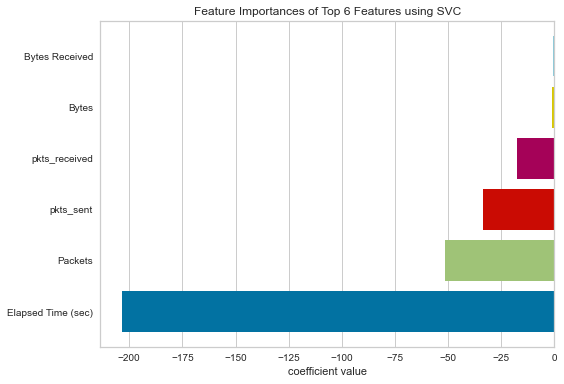

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using SVC'}, xlabel='coefficient value'>

In [31]:
viz = FeatureImportances(model, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()

# Conclusion

Both SVM and SGD models had very similar high accuracy result. For SVM, features such as "Elapsed Time(sec)", "Packets", "Pkts_sent" were the most contributing features to the model. For SGD, "Bytes Received", "Bytes" and "Elapsed Time(sec)" were the most important features. A more efficient way to model the data was tried using the result from the Association Rule Mining. Leveraging the insights in which certain items are highly associated with either Allow or Deny, it was found that we could achieve nearly the same model accuracy with 50% less dataset. Using the insights from the Association Rule Mining can drastically help save time and money especially for the startup company to quickly build the model with less amount of data and respond promptly to the malicious traffic. Further AR research can be conducted on a regular basis to catch the up-to-date trend of the malicious traffic and be continuously incorprated into the model.